# A2C 
---
In this notebook, you will implement a A2c agent with OpenAI Gym's xxx environment.

### 1. Import the Necessary Packages

Here I have used the difference between the Qvalue of the current state and the Monte Carlo reward. SO I am not expecting the variance to be low for this implementation. We will take care of that in the next implementations.

Here I have used one Optimizer for both the actor and critic. Feel free to split that up and check for your training environment

In [144]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 #print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
 print("GPU RAM Free: {0:.2f}GB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.2f}GB".format(gpu.memoryFree/1024, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal/1024))
printm()
###


!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb libav-tools xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
!pip install pyvirtualdisplay
##!pip install piglet
!pip install pyglet==1.3.2
!apt-get install xvfb
from pyvirtualdisplay import Display
!apt-get install cmake
!pip install setuptool
!pip install ez_setup
!pip install gym[atari] 

##

#import gym
##!pip3 install box2d
!pip install box2d-py
!pip install gym[Box_2D]
import gym

##
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


Gen RAM Free: 11.4 GB  | Proc size: 1.9 GB
GPU RAM Free: 10.84GB | Used: 338MB | Util   3% | Total 11.17GB
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package libav-tools is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  ffmpeg

E: Package 'libav-tools' has no installation candidate
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.3).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
  ERROR: Could not find a version that satisfies the requirement setu

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from   torch.optim import Adam
from torch.autograd import Variable
import gym
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.distributions import Categorical

In [0]:
# hyperparameters
hidden_size = 256
learning_rate = 3e-4

# Constants
GAMMA = 0.99
num_steps = 300 ## Here I am going till the end of any episode
n_episodes =4000

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:

  
#This code is from openai baseline
#https://github.com/openai/baselines/tree/master/baselines/common/vec_env

import numpy as np
from multiprocessing import Process, Pipe

def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close()
    env = env_fn_wrapper.x()
    while True:
        cmd, data = remote.recv()
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            remote.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            remote.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            remote.send(ob)
        elif cmd == 'close':
            remote.close()
            break
        elif cmd == 'get_spaces':
            remote.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError

class VecEnv(object):
    """
    An abstract asynchronous, vectorized environment.
    """
    def __init__(self, num_envs, observation_space, action_space):
        self.num_envs = num_envs
        self.observation_space = observation_space
        self.action_space = action_space

    def reset(self):
        """
        Reset all the environments and return an array of
        observations, or a tuple of observation arrays.
        If step_async is still doing work, that work will
        be cancelled and step_wait() should not be called
        until step_async() is invoked again.
        """
        pass

    def step_async(self, actions):
        """
        Tell all the environments to start taking a step
        with the given actions.
        Call step_wait() to get the results of the step.
        You should not call this if a step_async run is
        already pending.
        """
        pass

    def step_wait(self):
        """
        Wait for the step taken with step_async().
        Returns (obs, rews, dones, infos):
         - obs: an array of observations, or a tuple of
                arrays of observations.
         - rews: an array of rewards
         - dones: an array of "episode done" booleans
         - infos: a sequence of info objects
        """
        pass

    def close(self):
        """
        Clean up the environments' resources.
        """
        pass

    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()

    
class CloudpickleWrapper(object):
    """
    Uses cloudpickle to serialize contents (otherwise multiprocessing tries to use pickle)
    """
    def __init__(self, x):
        self.x = x
    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps(self.x)
    def __setstate__(self, ob):
        import pickle
        self.x = pickle.loads(ob)

        
class SubprocVecEnv(VecEnv):
    def __init__(self, env_fns, spaces=None):
        """
        envs: list of gym environments to run in subprocesses
        """
        self.waiting = False
        self.closed = False
        nenvs = len(env_fns)
        self.nenvs = nenvs
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = [Process(target=worker, args=(work_remote, remote, CloudpickleWrapper(env_fn)))
            for (work_remote, remote, env_fn) in zip(self.work_remotes, self.remotes, env_fns)]
        for p in self.ps:
            p.daemon = True # if the main process crashes, we should not cause things to hang
            p.start()
        for remote in self.work_remotes:
            remote.close()

        self.remotes[0].send(('get_spaces', None))
        observation_space, action_space = self.remotes[0].recv()
        VecEnv.__init__(self, len(env_fns), observation_space, action_space)

    def step_async(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action))
        self.waiting = True

    def step_wait(self):
        results = [remote.recv() for remote in self.remotes]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def reset_task(self):
        for remote in self.remotes:
            remote.send(('reset_task', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def close(self):
        if self.closed:
            return
        if self.waiting:
            for remote in self.remotes:            
                remote.recv()
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()
            self.closed = True
            
    def __len__(self):
        return self.nenvs


In [0]:
###Create Environment


#num_envs = 16
num_envs = 2
env_name = 'CartPole-v0'

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env
    return _thunk

envs =[make_env() for i in range(16)]
envs = SubprocVecEnv(envs)
env = gym.make(env_name)



In [0]:
##Actor Critic Network

In [0]:

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size=256):
        
        super(ActorCritic, self).__init__()

        self.num_inputs  = num_inputs
        self.num_actions = num_actions
        self.hidden_size = hidden_size

        ##critic
        self.critic_linear1 = nn.Linear(self.num_inputs, self.hidden_size)
        self.critic_linear2 = nn.Linear(self.hidden_size, 1)

        ##actors
        self.actor_linear1 = nn.Linear(self.num_inputs, self.hidden_size)
        self.actor_linear2 = nn.Linear(self.hidden_size, self.num_actions)   
    
    def forward(self, state):

        #state = Variable(torch.from_numpy(state).float().unsqueeze(0)).to(device)

        ##critic
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)

        ##actor
        probs = F.relu(self.actor_linear1(state))
        probs = F.softmax(self.actor_linear2(probs), dim=1)
        policy_dist = Categorical(probs)
        

        return value, policy_dist

In [0]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

In [0]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [0]:
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n

In [0]:
from collections import deque



def a2c(envs,num_inputs,num_actions,learning_rate,n_episodes,gamma=0.99):
    '''
    A2C
    Here I have passed a single environment
    '''


    actor_critic = ActorCritic(num_inputs, num_actions, hidden_size).to(device)
    ac_optimizer = Adam(actor_critic.parameters(), lr = learning_rate)
    checkpoint_filename= 'actor_critic.pth'

    #all_length = []
    #avg_length = []
    #all_reward = []
    #entropy_term = 0
    scores = []
    scores_deque = deque(maxlen =100)
    
    best_score = -np.inf

    for episode in range(1, n_episodes+1):
        log_probs = []
        values = []
        rewards = []
        masks =[]
        entropy = 0
        state = envs.reset()
        #print(state)
        score =0
        
        #for t in range(num_steps):
        while True:
            #print('1**')
            state = torch.FloatTensor(state).to(device)
            #print(state)
            value, policy_dist = actor_critic(state)

            action = policy_dist.sample()
            #print('2**')
            next_state, reward, done, _ = envs.step(action.cpu().numpy())
            
            log_prob = policy_dist.log_prob(action)
            entropy = policy_dist.entropy().mean()
            #print('3**')
            
            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
            masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
            score += reward

            state = next_state
            if np.any(done):
                break
            #print(score)
        ##Here one episode is done 

        ##We came out since any one of the episode has ended.
        ##So lets calculate the next_value of the last state
        #next_state = torch.FloatTensor(next_state).to(device)
        #next_value,_ = actor_critic(next_state)
        ##But I am penalizing it by not giving award since 
        ##one of the episode ended
        next_value =0.0
        ##You may alos set the next_value to  a negetive value 
        ##if the number of timesteps in one episode in less than may be 200 for example
        ##which means a failure has occured
        returns = compute_returns(next_value, rewards, masks, gamma)
        #print('4**')
        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)      
        ## Full Monte Carlo Reward used for calculating return 
        advantage = returns - values
        critic_loss = advantage.pow(2).mean()
        actor_loss = -(log_probs*advantage.detach()).mean()
        #print('5**')                   
        scores.append(score)
        scores_deque.append(score)
        loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy
        #print('6**')
        ac_optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(actor_critic.parameters(), 0.5)
        ac_optimizer.step()
        if np.mean(score) > best_score:
            best_score= np.mean(score)
            torch.save(actor_critic.state_dict(), checkpoint_filename)              
        print('\rEpisode: \t{} \tScore: \t{:.2f} \tAverage Score: \t{:.2f}'.format(episode, np.mean(score),
                                                                                 np.mean(scores_deque)), end=" ")                 
   
    return scores,scores_deque


In [31]:
scores,scores_deque = a2c(envs,num_inputs,num_actions,learning_rate,n_episodes,gamma=0.99)

Episode: 	4000 	Score: 	200.00 	Average Score: 	177.67 

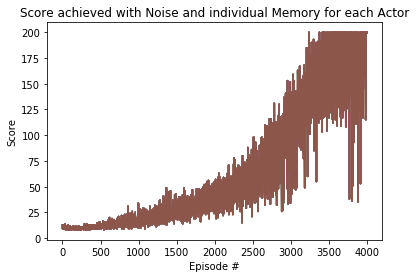

In [33]:
## With next_value equal to zero
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Score achieved with Noise and individual Memory for each Actor')
plt.show();

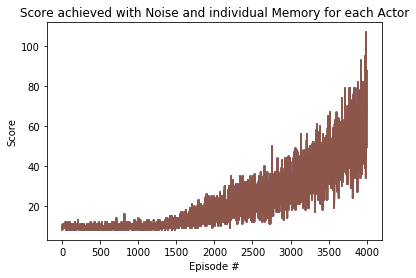

In [27]:
## With next_value not equal to zero
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Score achieved with Noise and individual Memory for each Actor')
plt.show();

In [0]:
##TO check my compute reward function

In [0]:
rewards =[1,2,3,4]
masks = [1,1,1,0]
next_value=2.0
gamma=0.99
R = next_value
returns = []
for step in reversed(range(len(rewards))):
    print(rewards[step])
    print('masks',masks[step])
    print('R',R)
    R = rewards[step] + gamma * R * masks[step]
    returns.insert(0, R)
    print(returns)

4
masks 0
R 2.0
[4.0]
3
masks 1
R 4.0
[6.96, 4.0]
2
masks 1
R 6.96
[8.8904, 6.96, 4.0]
1
masks 1
R 8.8904
[9.801496, 8.8904, 6.96, 4.0]


In [0]:
rewards =[1,2,3,4]
masks = [1,1,1,1]
next_value=2.0
gamma=0.99
R = next_value
returns = []
for step in reversed(range(len(rewards))):
    print(rewards[step])
    print('masks',masks[step])
    print('R',R)
    R = rewards[step] + gamma * R * masks[step]
    returns.insert(0, R)
    print(returns)

4
masks 1
R 2.0
[5.98]
3
masks 1
R 5.98
[8.920200000000001, 5.98]
2
masks 1
R 8.920200000000001
[10.830998000000001, 8.920200000000001, 5.98]
1
masks 1
R 10.830998000000001
[11.722688020000001, 10.830998000000001, 8.920200000000001, 5.98]
